# Extraction of documents:

1. Using regex to match the format of the file
2. Using CSR matrix for sparse representation of the document x words matrix.
3. Using tokenization to encode each word into token.


In [ ]:
import re
from collections import Counter
from scipy.sparse import csr_matrix
import numpy as np

def extract_documents_and_labels(dev_filename):
    pattern = r'<TRAIN\s+(\d+)\s+([^\n]+)>\n([\s\S]+?)(?=\n<TRAIN\s+\d+|$)'

    with open(dev_filename, 'r') as input_file:
        file_content = input_file.read()

    matches = re.findall(pattern, file_content)
    all_words = Counter(word for _, _, text in matches for word in text.lower().split())
    filtered_words = {word for word, count in all_words.items() if count > 3}
    vocabulary = {word: index for index, word in enumerate(filtered_words)}

    data, rows, cols = [], [], []
    document_labels = []

    for _, labels_str, document_text in matches:
        labels = labels_str.split('\t')
        document_labels.append(labels)

        word_counts = Counter(word for word in document_text.lower().split() if word in filtered_words)
        for word, count in word_counts.items():
            row_index = len(document_labels) - 1
            col_index = vocabulary[word]
            data.append(count)
            rows.append(row_index)
            cols.append(col_index)

    document_term_matrix = csr_matrix((data, (rows, cols)), shape=(len(document_labels), len(vocabulary)))
    return document_term_matrix, document_labels, vocabulary

# EM Implementation
1. All vectorized using numpy
2. Runtime approx 5 seconds to run.


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

class EM:
    def __init__(self, document_term_matrix, labels, vocabulary, num_clusters=9, epsilon=0.001, lambda_value=0.98, k=23.46):
        self.epsilon = np.float64(epsilon)
        self.lambda_value = np.float64(lambda_value)
        self.k = k
        self.document_term_matrix = document_term_matrix
        self.labels = labels
        self.vocabulary = vocabulary
        self.num_clusters = num_clusters
        self.w = np.zeros((document_term_matrix.shape[0], num_clusters), dtype=np.float64)
        self.alpha_i = np.zeros(num_clusters, dtype=np.float64)
        self.p_ki = np.zeros((len(vocabulary), num_clusters), dtype=np.float64)
        self.initialize_assignments()
        self.topics = ["acq", "money-fx", "grain", "crude", "trade", "interest", "ship", "wheat", "corn"]

    def initialize_assignments(self):
        """Assigns each document to a cluster in a circular manner using NumPy and initializes w."""
        num_documents = self.document_term_matrix.shape[0]
        assignments = np.arange(num_documents) % self.num_clusters
        self.w[np.arange(num_documents), assignments] = 1

        self.calculate_alpha_i()
        self.calculate_p_ki()

    def calculate_alpha_i(self):
        """Calculates and normalizes the probability of each class with smoothing, using NumPy."""
        num_documents = self.document_term_matrix.shape[0]
        raw_alpha_i = np.sum(self.w, axis=0) / num_documents

        adjusted_alpha_i = np.maximum(raw_alpha_i, self.epsilon)
        self.alpha_i = adjusted_alpha_i / np.sum(adjusted_alpha_i)

        assert np.all((0 <= self.alpha_i) & (self.alpha_i <= 1)), "All alpha_i values must be in the range [0, 1]."
        assert np.isclose(np.sum(self.alpha_i), 1, atol=1e-10), "Sum of alpha_i values must be 1."


    def calculate_p_ki(self):
        """Calculates the probability of word k in class i with Lidstone smoothing."""
        word_counts = self.document_term_matrix.sum(axis=1)

        for i in range(self.num_clusters):
            total_words = word_counts.T.dot(self.w[:, i])
            cluster_word_counts = self.document_term_matrix.T.dot(self.w[:, i])
            self.p_ki[:, i] = (cluster_word_counts + self.lambda_value) / (total_words + len(self.vocabulary) * self.lambda_value)

    def calculate_w(self):
        """Recalculates w, the probability of being in class i if document t is seen, with scaling to prevent underflow, using NumPy."""
        num_documents, num_vocabulary = self.document_term_matrix.shape
        num_clusters = self.num_clusters

        log_alpha_i = np.log(self.alpha_i)
        log_p_ki = np.log(self.p_ki)

        document_log_prob = self.document_term_matrix.dot(log_p_ki)
        log_prob_matrix = document_log_prob + log_alpha_i

        max_log_prob = np.max(log_prob_matrix, axis=1, keepdims=True)
        stabilized_log_prob_matrix = log_prob_matrix - max_log_prob

        mask = stabilized_log_prob_matrix >= -self.k
        stabilized_log_prob_matrix_masked = np.where(mask, stabilized_log_prob_matrix, -np.inf)

        exp_log_prob_matrix = np.exp(stabilized_log_prob_matrix_masked)
        w_sum = np.sum(exp_log_prob_matrix, axis=1, keepdims=True)
        self.w = exp_log_prob_matrix / w_sum

    def calculate_log_likelihood(self):
        num_documents, num_vocabulary = self.document_term_matrix.shape
        num_clusters = self.num_clusters

        log_alpha_i = np.log(self.alpha_i)
        log_p_ki = np.log(self.p_ki)

        document_log_prob = self.document_term_matrix.dot(log_p_ki) + log_alpha_i

        max_log_prob = np.max(document_log_prob, axis=1, keepdims=True)
        stabilized_log_prob_matrix = document_log_prob - max_log_prob

        exp_log_prob_matrix = np.exp(np.where(stabilized_log_prob_matrix >= -self.k, stabilized_log_prob_matrix, -np.inf))
        sum_exp_log_prob_matrix = np.sum(exp_log_prob_matrix, axis=1)
        log_likelihood = np.sum(max_log_prob.flatten() + np.log(sum_exp_log_prob_matrix))

        return log_likelihood

    def calculate_mean_perplexity(self, total_words, log_likelihood):
        mean_perplexity = np.exp(-log_likelihood / total_words)
        return mean_perplexity

    def expectation(self):
        """Performs the E-step by recalculating w."""
        self.calculate_w()

    def maximization(self):
        """Performs the M-step by recalculating alpha_i and p_ki."""
        self.calculate_alpha_i()
        self.calculate_p_ki()

    def hard_assignments(self):
        """Assigns each document to the cluster with the highest probability."""
        self.most_probable_clusters = np.argmax(self.w, axis=1)
        return self.most_probable_clusters

    def generate_confusion_matrix(self):
        num_clusters = self.num_clusters
        num_topics = len(self.topics)

        # Initialize counter array and the confusion matrix
        row_counts = np.zeros(num_clusters, dtype=int)
        confusion_matrix = np.zeros((num_clusters, num_topics + 1), dtype=int)

        for cluster_id, labels in zip(self.most_probable_clusters, self.labels):
            for label in labels:
                if label in self.topics:
                    topic_index = self.topics.index(label)
                    confusion_matrix[cluster_id, topic_index] += 1
                row_counts[cluster_id] += 1

        confusion_matrix[:, -1] = row_counts

        sorted_indices = np.argsort(-row_counts)
        sorted_confusion_matrix = confusion_matrix[sorted_indices]

        cluster_mapping = {original_index: new_index for new_index, original_index in enumerate(sorted_indices)}
        return sorted_confusion_matrix, cluster_mapping,

    def plot_histograms(self):
        sorted_confusion_matrix, cluster_mapping = self.generate_confusion_matrix()
        original_indices = {v: k for k, v in cluster_mapping.items()}

        for sorted_index, row in enumerate(sorted_confusion_matrix):
            original_cluster_id = original_indices[sorted_index]
            dominant_topic_index = np.argmax(row[:-1])
            dominant_topic = self.topics[dominant_topic_index]
            cluster_size = row[-1]

            # Plot histogram for the cluster
            plt.figure(figsize=(10, 6))
            plt.bar(self.topics, row[:-1], color='skyblue')
            plt.title(f'Cluster {original_cluster_id} - Dominant Topic: {dominant_topic} - Size: {cluster_size}')
            plt.xlabel('Topics')
            plt.ylabel('Number of Articles')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()

    def plot_confusion_matrix_and_accuracy(self):
        sorted_confusion_matrix, cluster_mapping = self.generate_confusion_matrix()
        original_to_sorted = {v: k for k, v in cluster_mapping.items()}

        # Accuracy calculation change
        accuracy = np.sum(np.max(sorted_confusion_matrix[:, :-1], axis=1)) / np.sum(sorted_confusion_matrix[:, -1])

        plt.figure(figsize=(10, 8))
        sns.heatmap(sorted_confusion_matrix[:, :-1], annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.topics,
                    yticklabels=[f"Cluster {cluster_mapping[i]} (Original {i})" for i in range(len(sorted_confusion_matrix))])
        plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.2f}')
        plt.xlabel('Topics')
        plt.ylabel('Clusters')
        plt.show()
        print(f"Accuracy: {accuracy:.2f}")

        return accuracy

    def run(self, max_iterations=100, convergence_threshold=1e-4):
        log_likelihoods = []
        perplexities = []

        total_words = self.document_term_matrix.sum()

        previous_log_likelihood = None
        for iteration in range(max_iterations):
            self.expectation()
            self.maximization()

            current_log_likelihood = self.calculate_log_likelihood()
            current_perplexity = self.calculate_mean_perplexity(total_words, current_log_likelihood)

            log_likelihoods.append(current_log_likelihood)
            perplexities.append(current_perplexity)

            assert not np.isnan(current_log_likelihood), "Log likelihood should not be NaN."
            assert not np.isinf(current_log_likelihood), "Log likelihood should not be inf."

            if previous_log_likelihood is not None and abs(current_log_likelihood - previous_log_likelihood) < convergence_threshold:
                print(f"Convergence reached at iteration {iteration}.")
                break

            previous_log_likelihood = current_log_likelihood
            print(f"Iteration {iteration}: Log Likelihood = {current_log_likelihood}")

        self.hard_assignments()

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(log_likelihoods, label='Log Likelihood')
        plt.xlabel('Iteration')
        plt.ylabel('Log Likelihood')
        plt.title('Log Likelihood over Iterations')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(perplexities, label='Mean Perplexity per Word')
        plt.xlabel('Iteration')
        plt.ylabel('Perplexity')
        plt.title('Mean Perplexity per Word over Iterations')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Find optimal hyperparameters: `lambda`, `k` values
1. Run til 60% accuracy score achieved

In [ ]:
documents, labels, voc = extract_documents_and_labels('/content/develop.txt')

In [ ]:
import random

def tune_lambda_for_accuracy(document_term_matrix, labels, vocabulary, num_clusters=9, epsilon=0.001,
                             min_lambda=0.001, max_lambda=1.0, min_k = 0, max_k = 50, target_accuracy=0.60):
    """Tries random lambda values with the EM model until the target accuracy is achieved."""

    best_accuracy = 0

    while best_accuracy < target_accuracy:
        lambda_value = random.uniform(min_lambda, max_lambda)
        k = random.uniform(min_k, max_k)
        print(f"Trying lambda_value: {lambda_value}, k: {k}")

        model = EM(document_term_matrix, labels, vocabulary, num_clusters, epsilon, lambda_value, k)
        model.run()


        current_accuracy = model.plot_confusion_matrix_and_accuracy()
        print(f"Current accuracy: {current_accuracy:.2f}")

        if current_accuracy > best_accuracy:
            best_model = model
            best_accuracy = current_accuracy

    print(f"Best model found with lambda={best_model.lambda_value}, accuracy={best_accuracy:.2f}")
    return best_model



Trying lambda_value: 0.6161795706545549, k: 14.938552682989082
Iteration 0: Log Likelihood = -2580051.2300350843
Iteration 1: Log Likelihood = -2561204.914176359
Iteration 2: Log Likelihood = -2545217.2142217048
Iteration 3: Log Likelihood = -2534131.935164026
Iteration 4: Log Likelihood = -2527311.204613179
Iteration 5: Log Likelihood = -2523746.656829499
Iteration 6: Log Likelihood = -2522094.463180519
Iteration 7: Log Likelihood = -2521029.754825784
Iteration 8: Log Likelihood = -2520153.3908262737
Iteration 9: Log Likelihood = -2519426.065583959
Iteration 10: Log Likelihood = -2518971.754417587
Iteration 11: Log Likelihood = -2518555.780617207
Iteration 12: Log Likelihood = -2518123.204798758
Iteration 13: Log Likelihood = -2517639.728666461
Iteration 14: Log Likelihood = -2516882.5177376526
Iteration 15: Log Likelihood = -2516714.6284059975
Iteration 16: Log Likelihood = -2516265.661712148
Iteration 17: Log Likelihood = -2516180.991936375
Iteration 18: Log Likelihood = -2516112.62

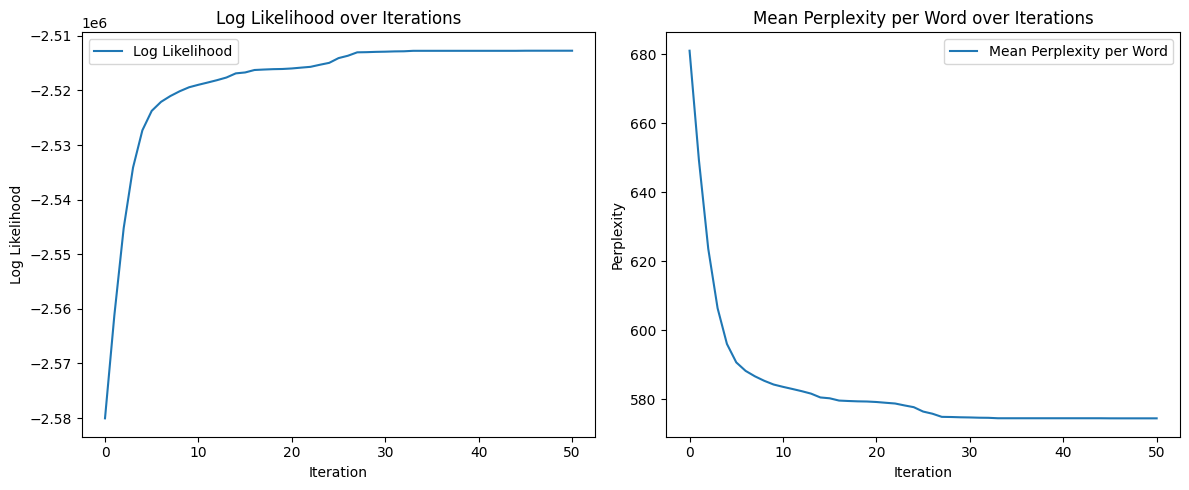

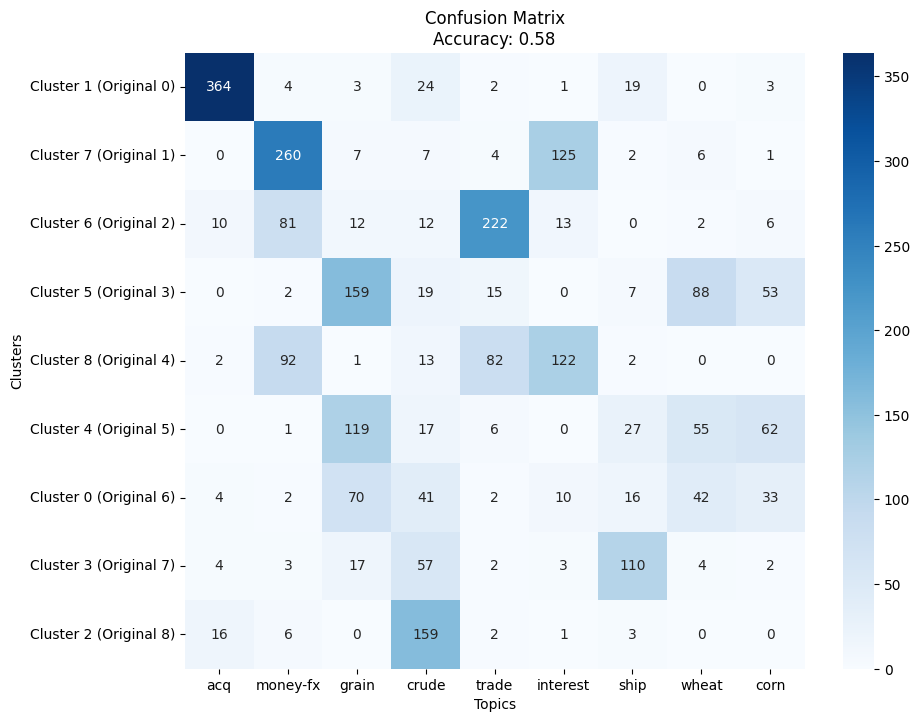

Accuracy: 0.58
Current accuracy: 0.58
Trying lambda_value: 0.4045818990725357, k: 15.128810479839478
Iteration 0: Log Likelihood = -2576623.6013150886
Iteration 1: Log Likelihood = -2560262.369670068
Iteration 2: Log Likelihood = -2545392.0279699145
Iteration 3: Log Likelihood = -2534885.1476236745
Iteration 4: Log Likelihood = -2526737.0402388396
Iteration 5: Log Likelihood = -2522193.817541032
Iteration 6: Log Likelihood = -2520150.3055800237
Iteration 7: Log Likelihood = -2518581.911703796
Iteration 8: Log Likelihood = -2517403.885656578
Iteration 9: Log Likelihood = -2516917.2483761767
Iteration 10: Log Likelihood = -2516382.8079786785
Iteration 11: Log Likelihood = -2515738.577815086
Iteration 12: Log Likelihood = -2515347.456505377
Iteration 13: Log Likelihood = -2514907.4988179565
Iteration 14: Log Likelihood = -2514768.2481353474
Iteration 15: Log Likelihood = -2514647.811292857
Iteration 16: Log Likelihood = -2514526.980304462
Iteration 17: Log Likelihood = -2514333.5126579455

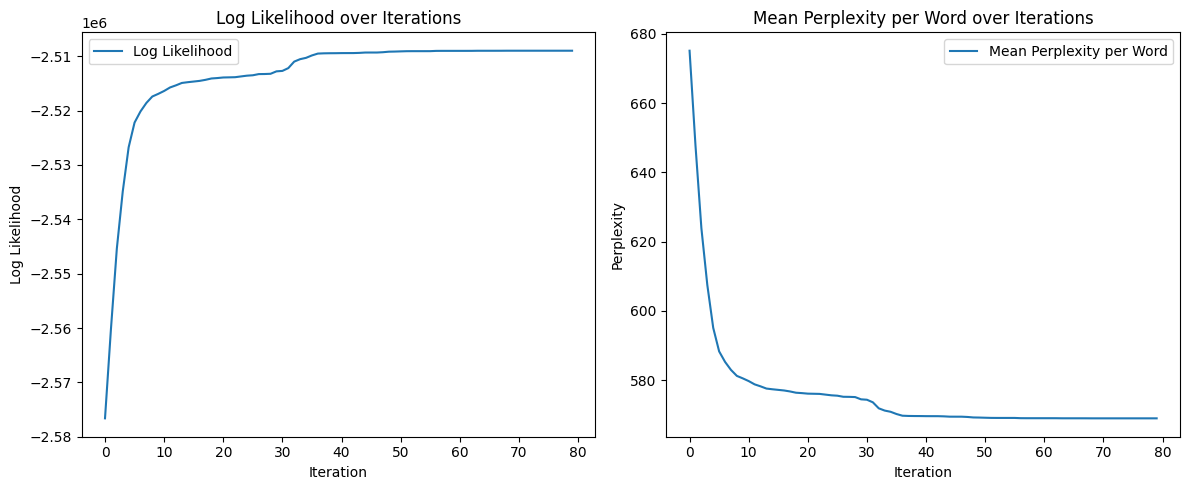

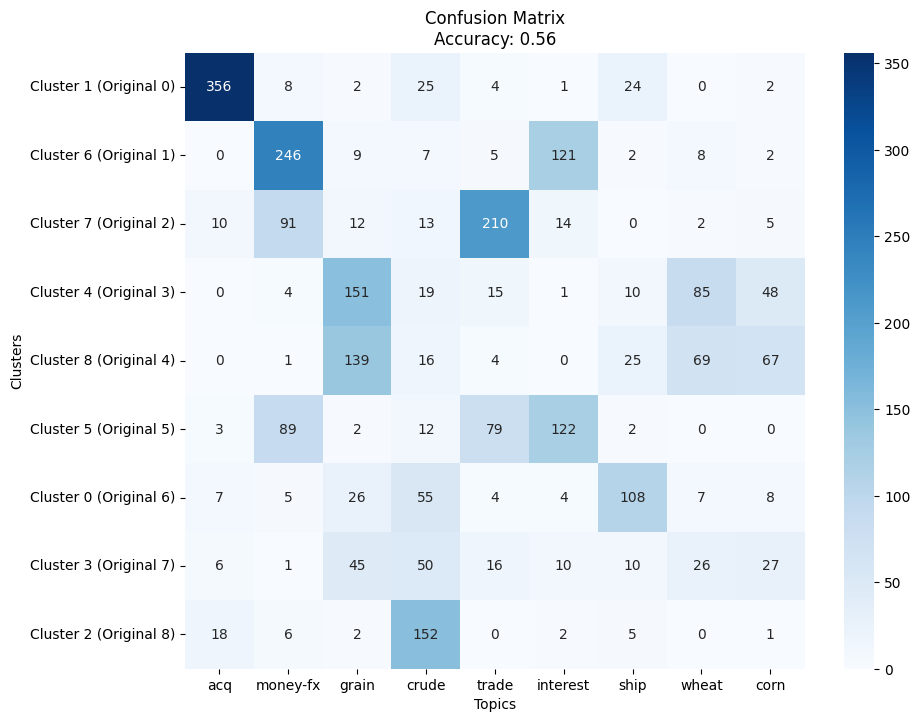

Accuracy: 0.56
Current accuracy: 0.56
Trying lambda_value: 0.988062072390148, k: 23.469289730272646
Iteration 0: Log Likelihood = -2586991.7183844363
Iteration 1: Log Likelihood = -2565114.5375716947
Iteration 2: Log Likelihood = -2548107.745456012
Iteration 3: Log Likelihood = -2537927.3365738327
Iteration 4: Log Likelihood = -2533845.7207510853
Iteration 5: Log Likelihood = -2530970.86975876
Iteration 6: Log Likelihood = -2528624.986023901
Iteration 7: Log Likelihood = -2527002.437112443
Iteration 8: Log Likelihood = -2526003.979909783
Iteration 9: Log Likelihood = -2524918.84375348
Iteration 10: Log Likelihood = -2523468.917230591
Iteration 11: Log Likelihood = -2522510.862148966
Iteration 12: Log Likelihood = -2521838.647925292
Iteration 13: Log Likelihood = -2521282.887354765
Iteration 14: Log Likelihood = -2521037.514502176
Iteration 15: Log Likelihood = -2520671.7452244284
Iteration 16: Log Likelihood = -2520522.211363482
Iteration 17: Log Likelihood = -2520350.1314002397
Iterat

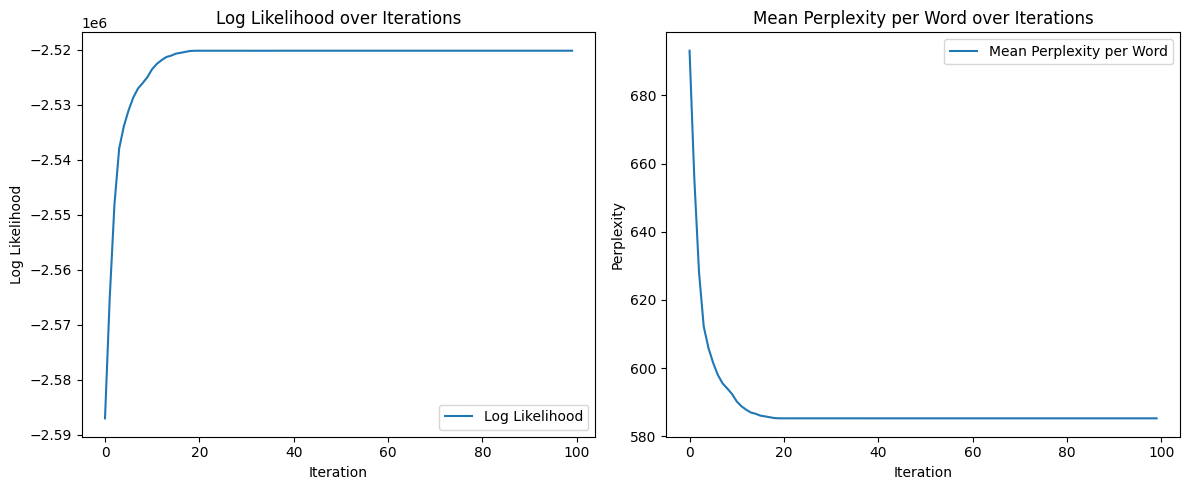

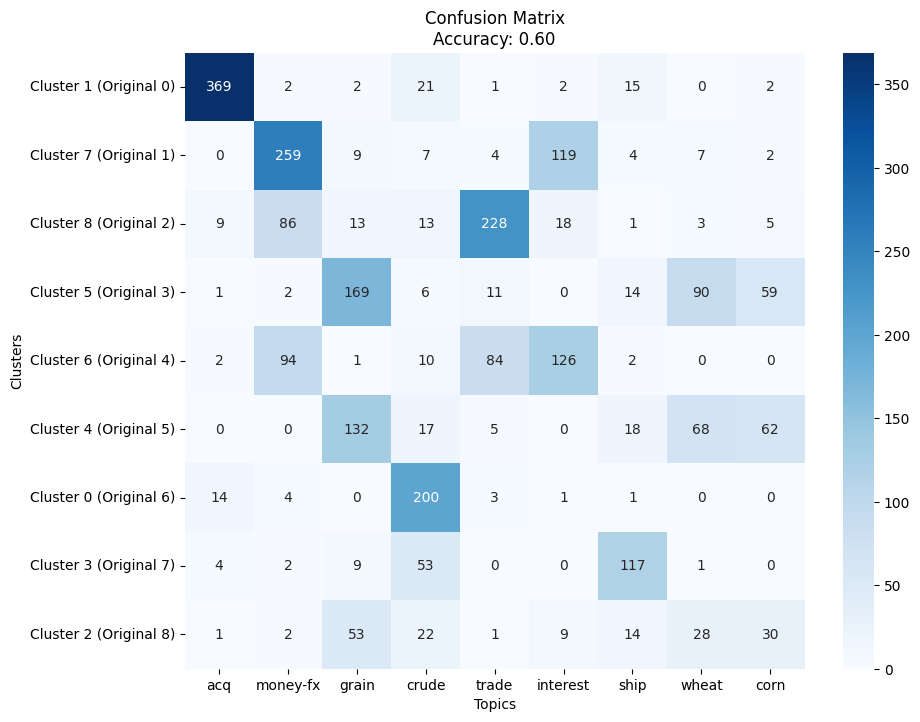

Accuracy: 0.60
Current accuracy: 0.60
Best model found with lambda=0.988062072390148, accuracy=0.60


In [ ]:
documents, labels, voc = extract_documents_and_labels('/content/develop.txt')
tune_lambda_for_accuracy(documents, labels, voc)

# Running the algorithm:

In [ ]:
exp_max = EM(documents, labels, voc)

Iteration 0: Log Likelihood = -2586834.648747394
Iteration 1: Log Likelihood = -2564986.9197669835
Iteration 2: Log Likelihood = -2547985.051830735
Iteration 3: Log Likelihood = -2537802.2346825683
Iteration 4: Log Likelihood = -2533710.1729736547
Iteration 5: Log Likelihood = -2530792.8913414
Iteration 6: Log Likelihood = -2528451.10949115
Iteration 7: Log Likelihood = -2526857.2989377026
Iteration 8: Log Likelihood = -2525814.3349871477
Iteration 9: Log Likelihood = -2524726.2611619076
Iteration 10: Log Likelihood = -2523286.118114292
Iteration 11: Log Likelihood = -2522351.2773232153
Iteration 12: Log Likelihood = -2521657.3302585753
Iteration 13: Log Likelihood = -2521158.58481937
Iteration 14: Log Likelihood = -2520817.9922521003
Iteration 15: Log Likelihood = -2520504.209781943
Iteration 16: Log Likelihood = -2520274.630132839
Iteration 17: Log Likelihood = -2520110.5362847336
Iteration 18: Log Likelihood = -2519951.6397165554
Iteration 19: Log Likelihood = -2519902.682941949
Ite

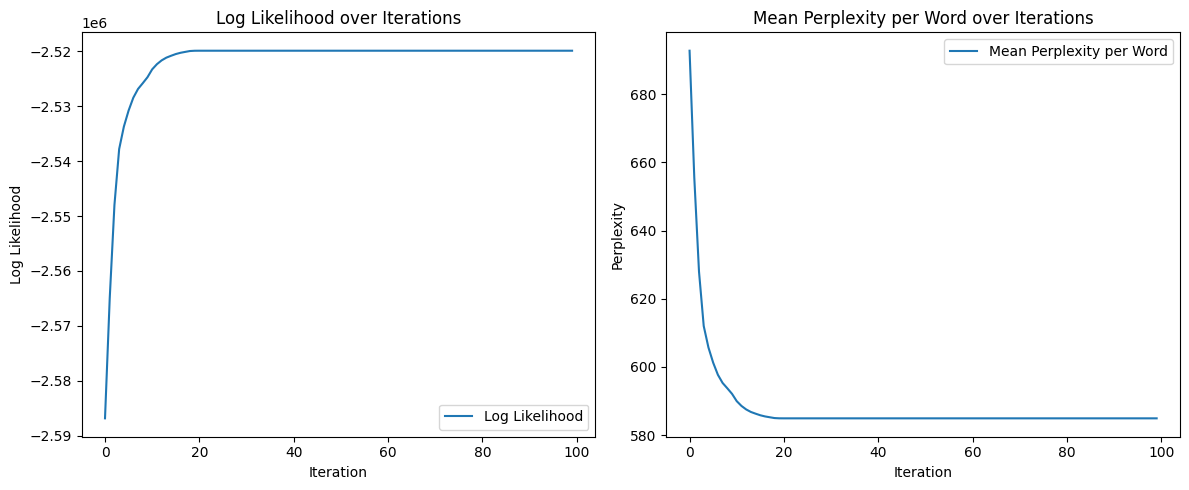

In [ ]:
exp_max.run()

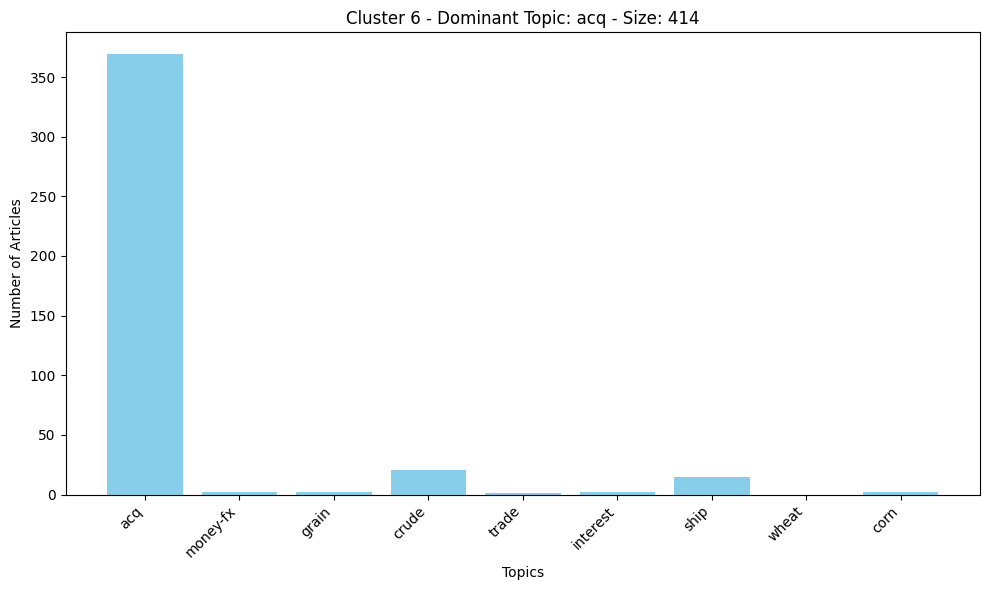

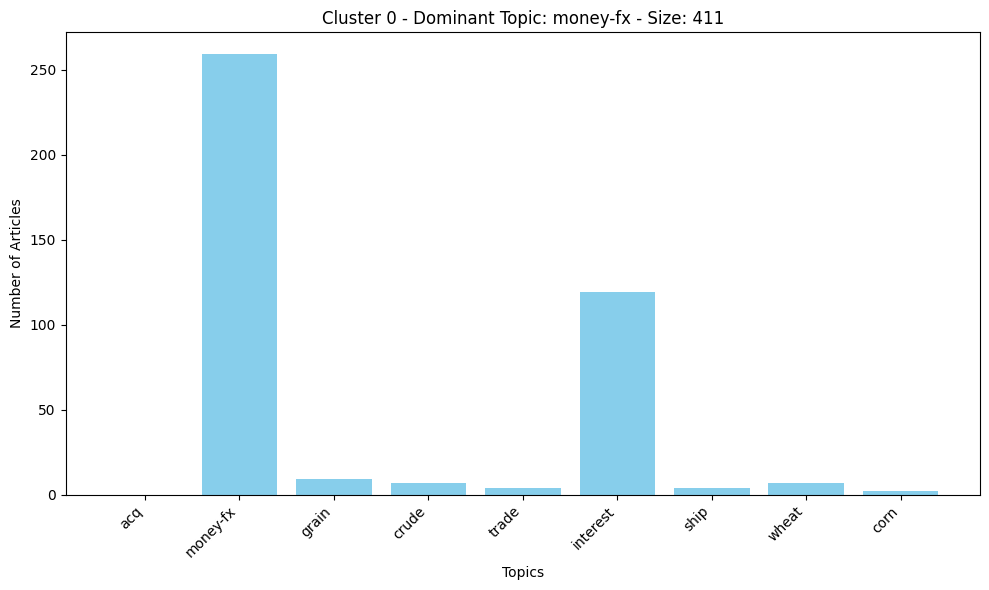

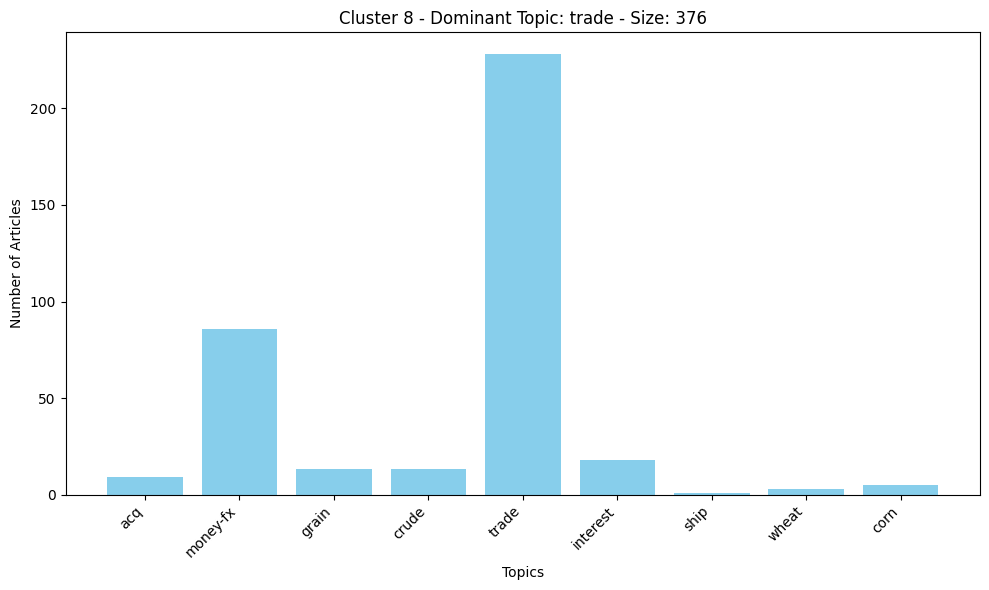

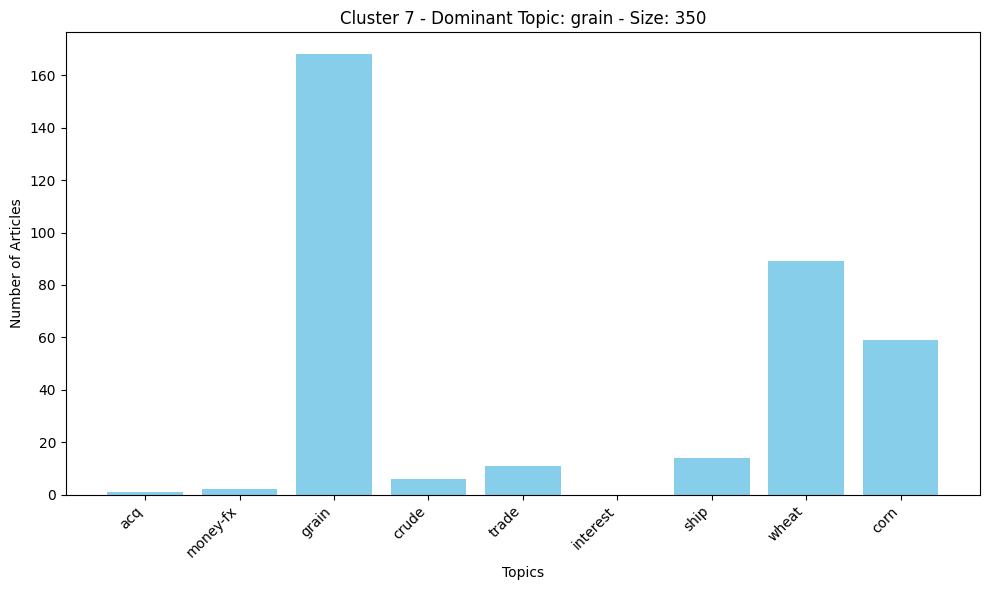

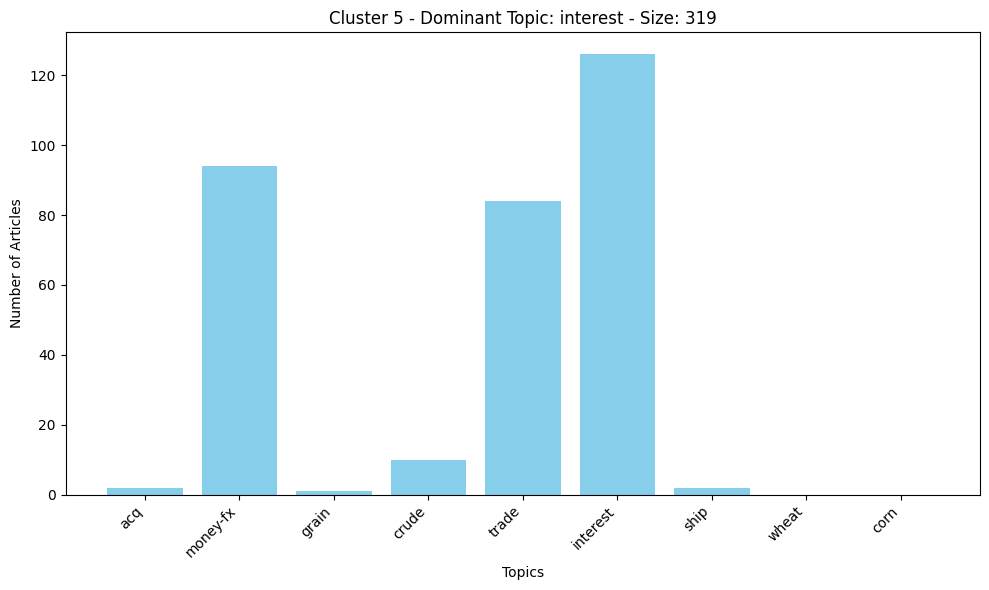

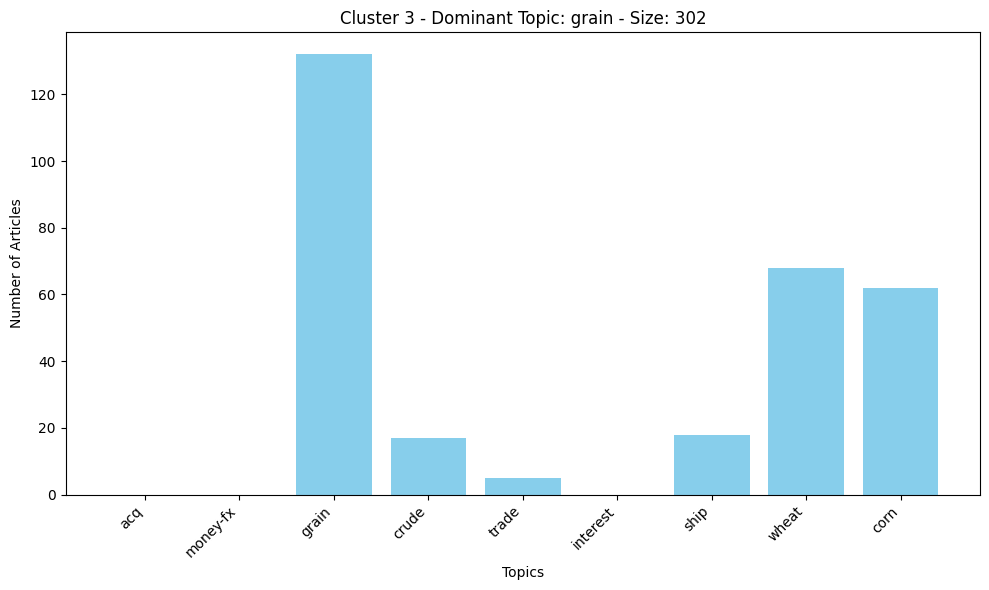

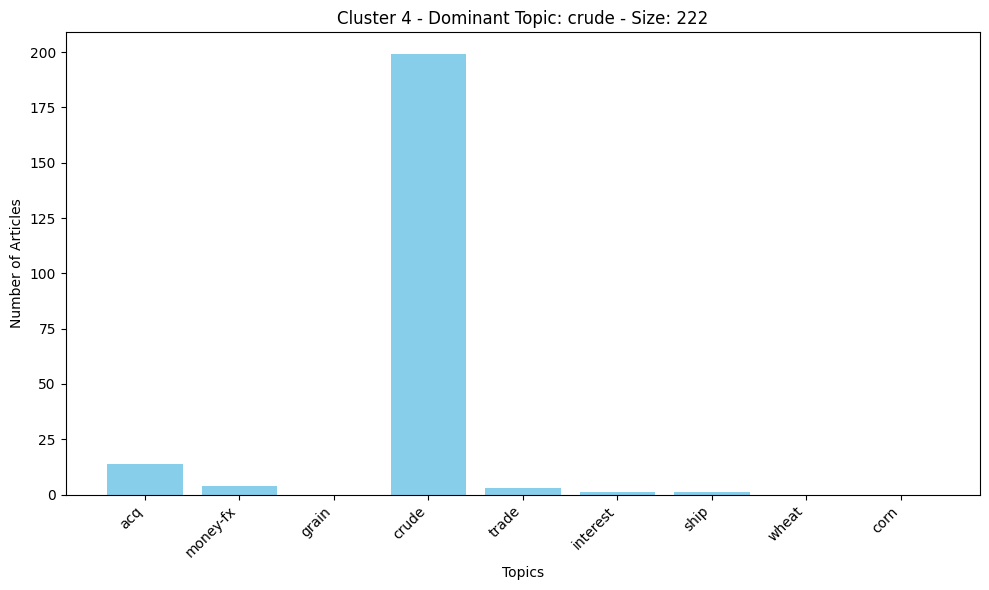

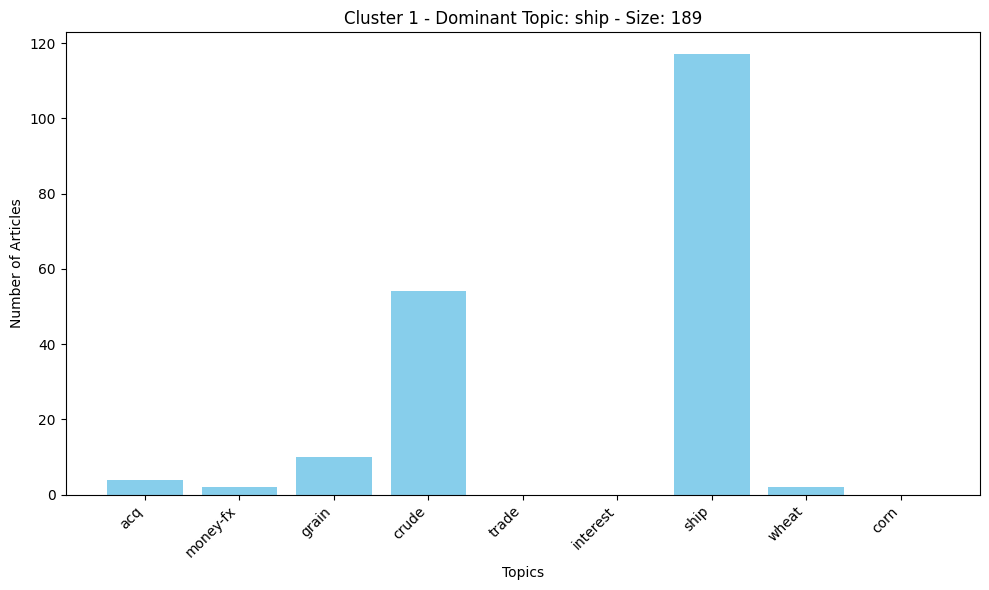

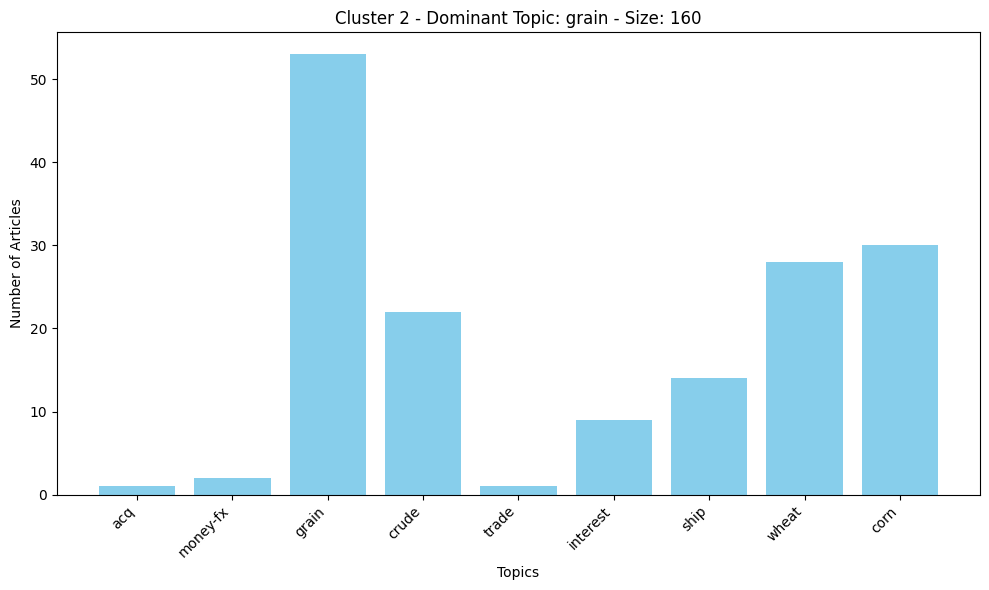

In [ ]:
exp_max.plot_histograms()

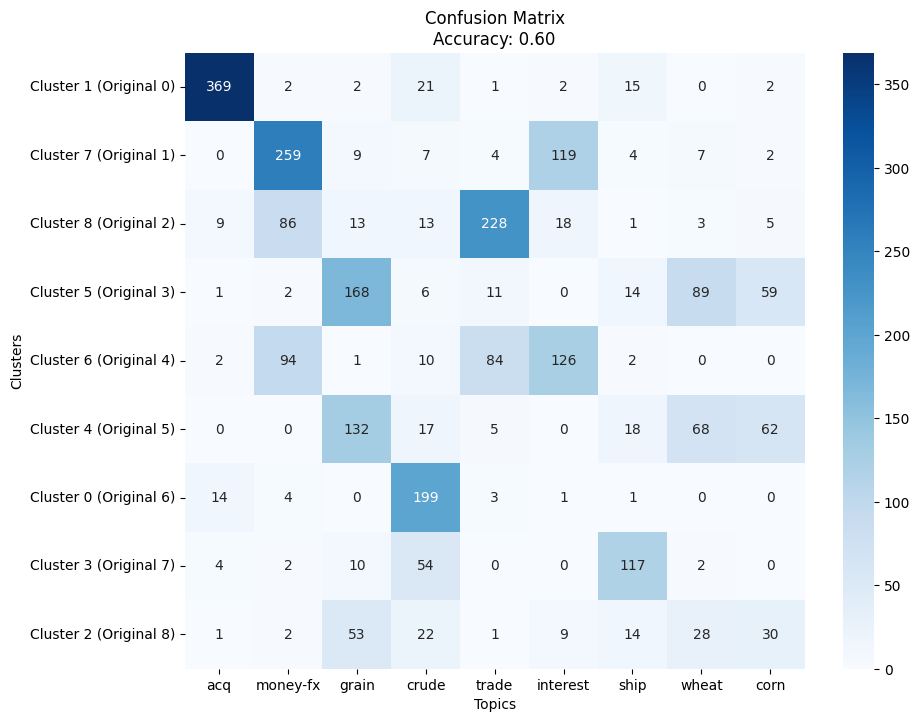

Accuracy: 0.60


0.6018957345971564

In [ ]:
import seaborn as sns
exp_max.plot_confusion_matrix_and_accuracy()